In [5]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [6]:
# Define image size and paths
IMG_SIZE = (128, 128)
DATASET_PATH = 'Archive'

# Initialize lists to hold images and labels
images = []
labels = []

# Define gesture labels (adjust according to your dataset)
gesture_labels = {
    'palm': 0,
    'l': 1,
    'fist': 2,
    'fist_moved': 3,
    'thumb': 4,
    'index': 5,
    'ok': 6,
    'palm_moved': 7,
    'c': 8,
    'down': 9
}

# Traverse the directory structure to load images
for subject_folder in os.listdir(DATASET_PATH):
    subject_path = os.path.join(DATASET_PATH, subject_folder)
    if os.path.isdir(subject_path):
        for gesture_folder in os.listdir(subject_path):
            gesture_path = os.path.join(subject_path, gesture_folder)
            if os.path.isdir(gesture_path):
                for image_file in os.listdir(gesture_path):
                    image_path = os.path.join(gesture_path, image_file)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    image = cv2.resize(image, IMG_SIZE)
                    images.append(image)
                    gesture = gesture_folder.split('_')[1]
                    labels.append(gesture_labels[gesture])

# Convert lists to arrays
images = np.array(images)
labels = np.array(labels)

# Normalize pixel values
images = images / 255.0

# Add a channel dimension
images = np.expand_dims(images, axis=-1)

# Convert labels to categorical format
labels = to_categorical(labels, num_classes=len(gesture_labels))

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Print the shapes of the datasets
print(f"Training set shape: {X_train.shape}, {y_train.shape}")
print(f"Validation set shape: {X_val.shape}, {y_val.shape}")
print(f"Test set shape: {X_test.shape}, {y_test.shape}")

Training set shape: (14000, 128, 128, 1), (14000, 10)
Validation set shape: (3000, 128, 128, 1), (3000, 10)
Test set shape: (3000, 128, 128, 1), (3000, 10)


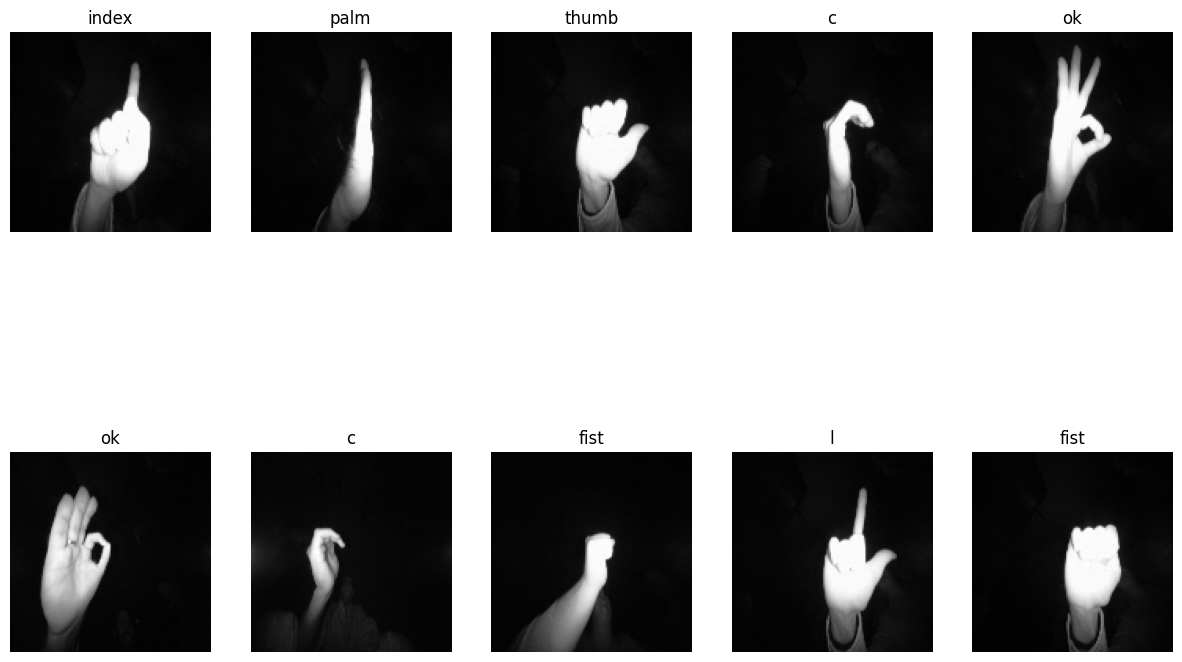

In [7]:
# Define a function to display sample images with their labels
def plot_sample_images(images, labels, gesture_labels, num_samples=10):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        index = np.random.randint(0, len(images))
        image = images[index].squeeze()
        label = np.argmax(labels[index])
        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(list(gesture_labels.keys())[label])
        plt.axis('off')
    plt.show()

# Plot some sample images
plot_sample_images(X_train, y_train, gesture_labels)


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(gesture_labels), activation='softmax')
])

# Print the model summary
model.summary()


C:\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,354 (12.61 MB)

 Trainable params: 3,305,354 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Fit the generator to the training data
datagen.fit(X_train)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
)


Epoch 1/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 797s 2s/step - accuracy: 0.8948 - loss: 0.3024 - val_accuracy: 0.9980 - val_loss: 0.0169
Epoch 2/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 786s 2s/step - accuracy: 0.9537 - loss: 0.1435 - val_accuracy: 0.9990 - val_loss: 0.0062
Epoch 3/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 789s 2s/step - accuracy: 0.9729 - loss: 0.0986 - val_accuracy: 0.9973 - val_loss: 0.0095
Epoch 4/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 798s 2s/step - accuracy: 0.9769 - loss: 0.0746 - val_accuracy: 0.9993 - val_loss: 0.0037
Epoch 5/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 799s 2s/step - accuracy: 0.9765 - loss: 0.0718 - val_accuracy: 0.9993 - val_loss: 0.0022
Epoch 6/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 797s 2s/step - accuracy: 0.9823 - loss: 0.0621 - val_accuracy: 0.9997 - val_loss: 0.0027
Epoch 7/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 794s 2s/step - accuracy: 0.9857 - loss: 0.0438 - val_accuracy: 0.9993 - val_loss: 0.0019
Epoch 8/10
438/438 ━━━━━━━━━━━━━━━━━━━━ 796s 2s/step - accuracy: 0.9835 - loss: 0.0509 - val_accu

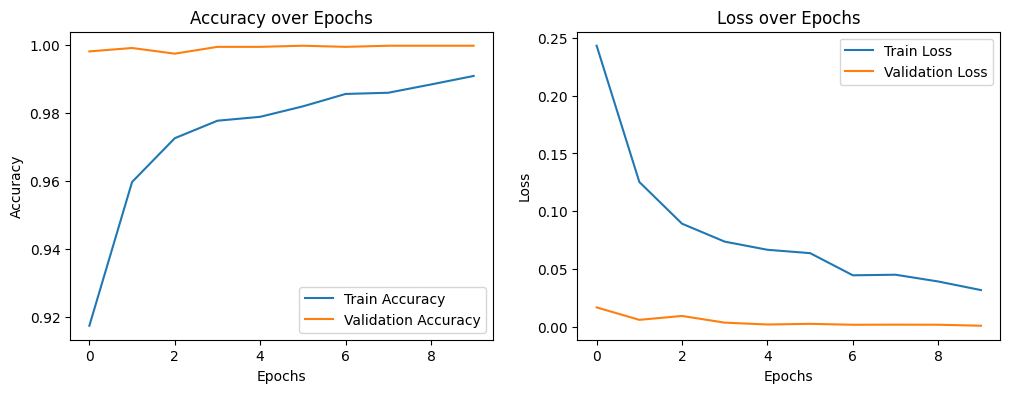

In [12]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()


94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 275ms/step - accuracy: 1.0000 - loss: 8.8400e-05
Test accuracy: 100.00%
94/94 ━━━━━━━━━━━━━━━━━━━━ 26s 272ms/step


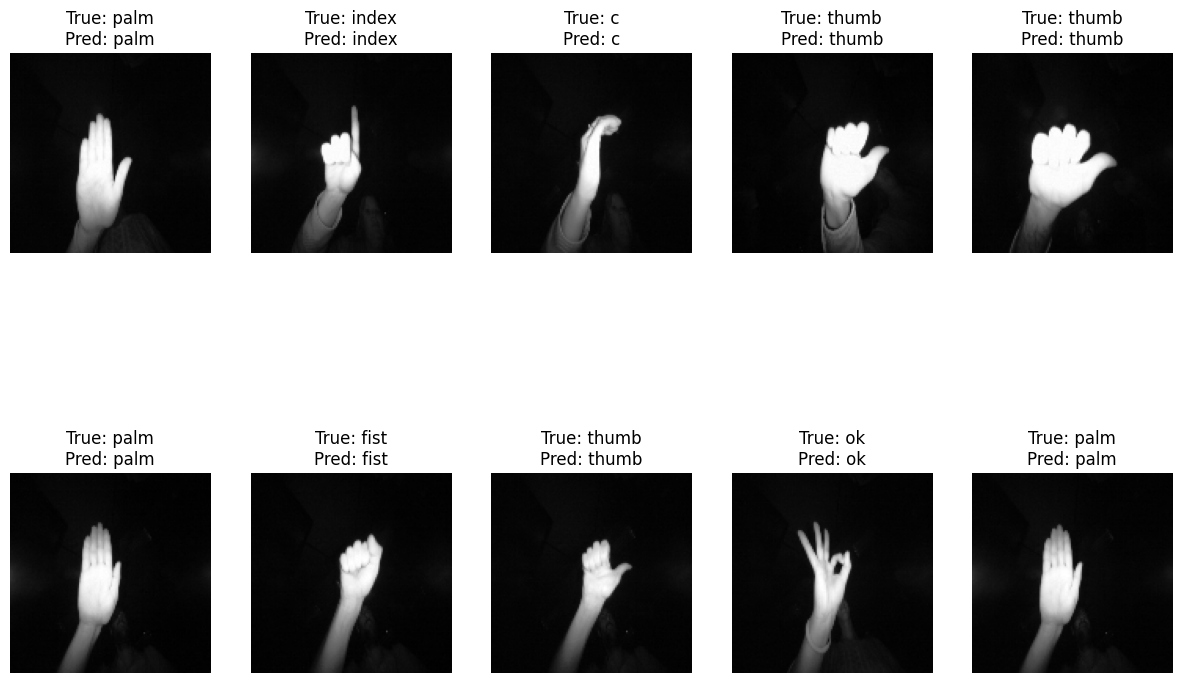

In [13]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Define a function to plot predictions
def plot_predictions(images, labels, predictions, gesture_labels, num_samples=10):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        index = np.random.randint(0, len(images))
        image = images[index].squeeze()
        true_label = np.argmax(labels[index])
        pred_label = np.argmax(predictions[index])
        plt.subplot(2, 5, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"True: {list(gesture_labels.keys())[true_label]}\nPred: {list(gesture_labels.keys())[pred_label]}")
        plt.axis('off')
    plt.show()

# Make predictions on the test set
predictions = model.predict(X_test)

# Plot some predictions
plot_predictions(X_test, y_test, predictions, gesture_labels)


In [19]:
import cv2

# Define a function to predict the gesture from a frame
def predict_gesture(frame):
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, IMG_SIZE)
    normalized = resized / 255.0
    reshaped = np.expand_dims(normalized, axis=(0, -1))
    prediction = model.predict(reshaped)
    gesture = np.argmax(prediction)
    return gesture

# Open a video capture object
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    gesture = predict_gesture(frame)
    gesture_name = list(gesture_labels.keys())[list(gesture_labels.values()).index(gesture)]
    
    # Display the result
    cv2.putText(frame, gesture_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow('Gesture Recognition', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1295: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvDestroyAllWindows'
